## Wczytanie bibliotek

In [109]:
import numpy as np  
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs, make_moons, load_iris, load_digits
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score, v_measure_score
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage
from sklearn.decomposition import PCA
from kneed import KneeLocator
import time
from joblib import cpu_count

%matplotlib inline

# Porównanie i ocena algorytmów grupowania 

### Przykład 1: miary ARI, V-measure i współczynnik sylwetki dla danych two moons

Dla danych two moons porównaj grupowanie k-średnich, aglomeracyjne i DBSCAN przy użyciu ARI, V-measure i współczynnika sylwetki. 
Porównaj wyniki także z losowym przypisaniem punktów do dwóch klastrów. Zwizualizuj wyniki.

In [3]:
X, y = make_moons(n_samples = 200, noise = .05, random_state = 7)

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

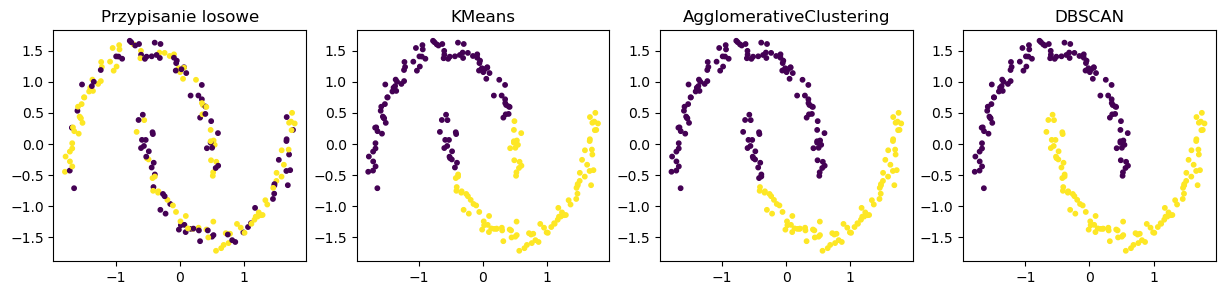

In [9]:
fig, axes = plt.subplots(1, 4, figsize = (15, 3))
algorithms = [KMeans(n_clusters = 2, n_init = 10), AgglomerativeClustering(n_clusters = 2), DBSCAN()]
# losowe przypisanie
random_state = np.random.RandomState(seed = 7)
random_clusters = random_state.randint(low = 0, high = 2, size = len(X)) # 0 i 1
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c = random_clusters, s = 10)
axes[0].set_title("Przypisanie losowe")
indeksy = pd.DataFrame(columns = ["Przypisanie losowe", "KMeans", "AgglomerativeClustering", "DBSCAN"], 
                       index = ["ARI", "V-measure", "silhouette_score"])
indeksy["Przypisanie losowe"] = [adjusted_rand_score(y, random_clusters), v_measure_score(y, random_clusters), 
                                silhouette_score(X_scaled, random_clusters)]
for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c = clusters, s = 10)
    alg_str = str(algorithm).split("(")[0]
    ax.set_title(alg_str)
    indeksy[alg_str] = [adjusted_rand_score(y, clusters), v_measure_score(y, clusters), 
                                silhouette_score(X_scaled, clusters)]
plt.show()


In [10]:
round(indeksy, 2)

,Przypisanie losowe,KMeans,AgglomerativeClustering,DBSCAN
ARI,-0.0,0.47,0.65,1.00
V-measure,0.0,0.38,0.63,1.00
silhouette_score,0.0,0.49,0.45,0.38


In [11]:
print(pd.crosstab(clusters, y))

col_0    0    1
row_0          
0      100    0
1        0  100


In [12]:
print(pd.crosstab(random_clusters, y))

col_0   0   1
row_0        
0      44  50
1      56  50


### Ćwiczenie 1: miary ARI i V-measure dla danych Irysy

Dla danych Irysy porównaj grupowania znalezione przez algorytmy grupowania k-średnich i aglomeracyjne
za pomocą indeksu ARI i V-measure. Zwizualiuj wyniki.

In [14]:
iris = load_iris()
y = iris.target

In [15]:
np.bincount(y)

array([50, 50, 50])

In [16]:
X_scaled = StandardScaler().fit_transform(iris.data)

In [17]:
indeksy = pd.DataFrame(columns = ["KMeans", "AgglomerativeClustering complete", "AgglomerativeClustering ward"], 
                      index = ["ARI", "V-measure"])


In [18]:
model = KMeans(n_clusters = 3, n_init = 10, random_state = 7)
model.fit(X_scaled)
labels = model.labels_
indeksy["KMeans"] = [adjusted_rand_score(y,  labels), v_measure_score(y, labels)]

In [20]:
L1 = linkage(X_scaled, method = "complete", metric = "euclidean")
L2 = linkage(X_scaled, method = "ward", metric = "euclidean")

In [21]:
clust1 = fcluster(L1, 3, criterion = "maxclust")
clust2 = fcluster(L2, 2, criterion = "maxclust")

In [22]:
indeksy["AgglomerativeClustering complete"] = [adjusted_rand_score(y,  clust1), v_measure_score(y, clust1)]

In [23]:
indeksy["AgglomerativeClustering ward"] = [adjusted_rand_score(y,  clust2), v_measure_score(y, clust2)]

In [24]:
round(indeksy, 2)

,KMeans,AgglomerativeClustering complete,AgglomerativeClustering ward
ARI,0.59,0.57,0.54
V-measure,0.64,0.65,0.69


In [25]:
# Single linkage k = 3 Vmeasure = 0.72, ARI = 0.56
# Average linkage k = 4 Vmeasure = 0.7, ARI = 0.55

In [28]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)

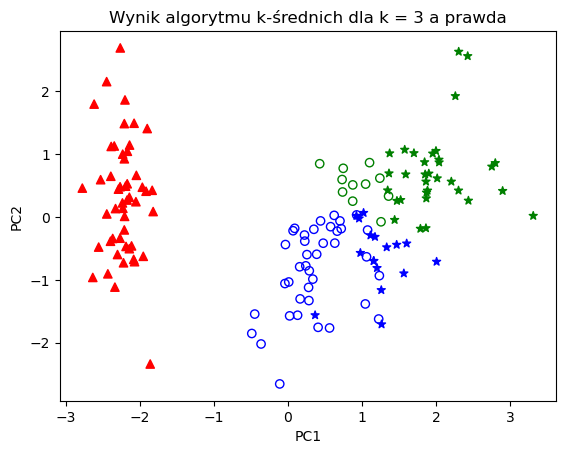

In [30]:
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], c = np.array(["red", "blue", "green"])[np.array(labels[y == 0])], marker = "^")
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], edgecolors = np.array(["red", "blue", "green"])[np.array(labels[y == 1])],
            marker = "o", facecolors = "none")
plt.scatter(X_pca[y == 2, 0], X_pca[y == 2, 1], c = np.array(["red", "blue", "green"])[np.array(labels[y == 2])], marker = "*")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Wynik algorytmu k-średnich dla k = 3 a prawda")
plt.show()

In [31]:
print(pd.crosstab(labels, y))

col_0   0   1   2
row_0            
0      50   0   0
1       0  39  17
2       0  11  33


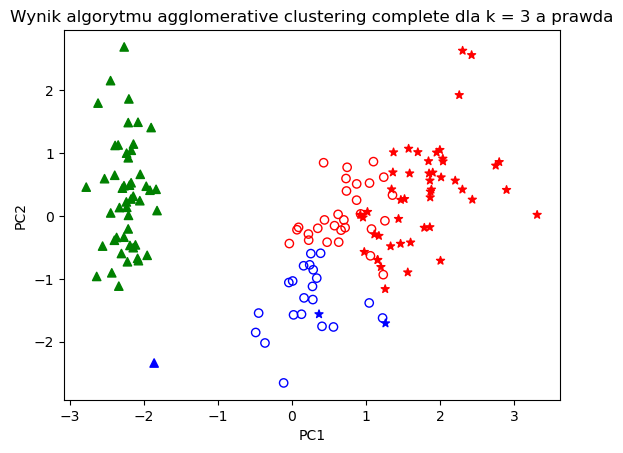

In [33]:
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], c = np.array(["red", "blue", "green"])[np.array(clust1[y == 0])-1], marker = "^")
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], edgecolors = np.array(["red", "blue", "green"])[np.array(clust1[y == 1]-1)],
            marker = "o", facecolors = "none")
plt.scatter(X_pca[y == 2, 0], X_pca[y == 2, 1], c = np.array(["red", "blue", "green"])[np.array(clust1[y == 2]-1)], marker = "*")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Wynik algorytmu agglomerative clustering complete dla k = 3 a prawda")
plt.show()

In [34]:
print(pd.crosstab(clust1, y))

col_0   0   1   2
row_0            
1       0  29  48
2       1  21   2
3      49   0   0


In [35]:
adjusted_rand_score(clust1, labels)

0.559377230043409

In [36]:
adjusted_rand_score(clust2, labels)

0.5496328671013193

# Grupowanie danych mieszanych

### Przykład 2: grupowanie danych mieszanych blobs za pomocą kodowania binarnego zmiennych kategorialnych

Dla danych blobs zakoduj zmienną kategorialną za pomocą zmiennych binarnych i zgrupuj dane za pomocą 
klateryzacji k-średnich z liczbą klastrów równą 3. Policz ARI i porównaj wynik klasteryzacji do klasteryzacji 
k-średnich tylko na zmiennych ciągłych.  

In [37]:
X, y = make_blobs(n_samples = 100, centers = 3, n_features = 3, center_box=[-6, 6], random_state = 1234)
X = pd.DataFrame(X, columns=['X1', 'X2', 'X3'])
X['X3'] = np.where(X['X3'] < -2, 'LOW', np.where(X['X3'] > 2, 'HIGH', 'MEDIUM'))

In [40]:
X.head()

,X1,X2,X3
0,-3.890860,0.092066,MEDIUM
1,-2.311276,4.550265,HIGH
2,-4.032373,2.339433,MEDIUM
3,4.668072,4.093457,LOW
4,-2.588132,1.091546,HIGH


In [41]:
con = ["X1", "X2"]
cat = "X3"

In [42]:
# skalowanie zmiennych ciągłych
scaler = StandardScaler()
X[con] = scaler.fit_transform(X[con])

In [43]:
X["X3"].value_counts()

MEDIUM    41
HIGH      33
LOW       26
Name: X3, dtype: int64

In [44]:
X_dum = pd.get_dummies(X, drop_first = True)

In [45]:
X_dum

,X1,X2,X3_LOW,X3_MEDIUM
0,-0.953471,-2.206143,0,1
1,-0.450817,1.346499,0,0
2,-0.998503,-0.415265,0,1
3,1.770144,0.982478,1,0
4,-0.538918,-1.409679,0,0
...,...,...,...,...
95,-1.098665,-0.765337,0,1
96,-0.583274,0.946393,0,0
97,-0.734585,-1.062558,0,1
98,-0.407255,0.828192,0,0


In [46]:
scaler2 = StandardScaler()
X_dum[["X3_LOW", "X3_MEDIUM"]] = scaler2.fit_transform(X_dum[["X3_LOW", "X3_MEDIUM"]])

In [47]:
X_dum

,X1,X2,X3_LOW,X3_MEDIUM
0,-0.953471,-2.206143,-0.592749,1.199593
1,-0.450817,1.346499,-0.592749,-0.833616
2,-0.998503,-0.415265,-0.592749,1.199593
3,1.770144,0.982478,1.687055,-0.833616
4,-0.538918,-1.409679,-0.592749,-0.833616
...,...,...,...,...
95,-1.098665,-0.765337,-0.592749,1.199593
96,-0.583274,0.946393,-0.592749,-0.833616
97,-0.734585,-1.062558,-0.592749,1.199593
98,-0.407255,0.828192,-0.592749,-0.833616


In [48]:
model = KMeans(n_clusters = 3, random_state = 7, n_init = 10)
model.fit(X_dum)
labels = model.labels_

In [50]:
adjusted_rand_score(labels, y)

0.719614257190195

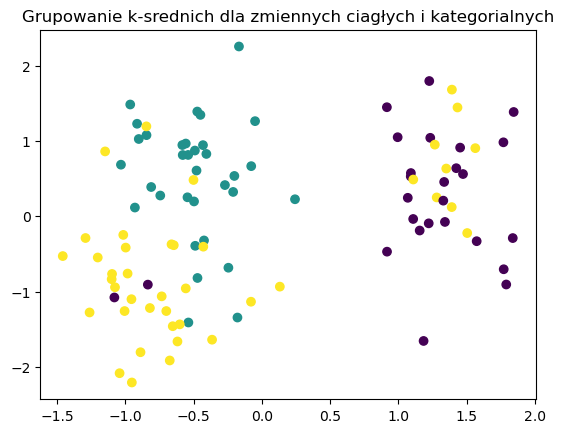

In [52]:
plt.scatter(X_dum["X1"], X_dum["X2"], c = labels) # można PCA, można dosać kształty pktów jako X3
plt.title("Grupowanie k-srednich dla zmiennych ciagłych i kategorialnych")
plt.show()

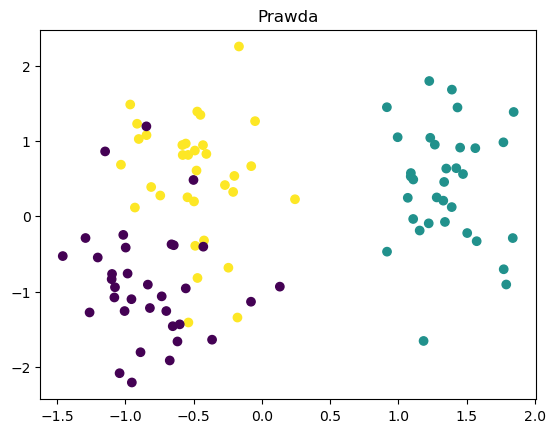

In [53]:
plt.scatter(X_dum["X1"], X_dum["X2"], c = y) # można PCA, można dosać kształty pktów jako X3
plt.title("Prawda")
plt.show()

In [54]:
model2 = KMeans(n_clusters = 3, random_state = 7, n_init = 10)
model2.fit(X_dum[["X1", "X2"]])
labels2 = model2.labels_

In [55]:
adjusted_rand_score(labels2, y)

0.7293278537362832

### Ćwiczenie 2: grupowanie danych mieszanych heart za pomocą kodowania binarnego zmiennych kategorialnych

Dla danych heart zakoduj zmienne kategorialne za pomocą zmiennych binarnych i zgrupuj dane za pomocą 
klateryzacji k-średnich z liczbą klastrów równą 2. Policz ARI i porównaj wynik klasteryzacji do klasteryzacji 
k-średnich tylko na zmiennych ciągłych. Zaprezentuj wyniki lepszej metody na wykresie.

In [173]:
heart = pd.read_csv("heart.csv")

Zbiór danych Cleveland Heart Disease pochodzi z repozytorium UCI machine learning. Zawiera 13 zmiennych, z czego 5 numerycznych i 8 kategorialnych. Liczba pacjentów jest równa 303, zmienną objaśnianą jest binarna zmienna mówiąca o obecności choroby serca. Kolumna target będzie nam służyła do oceny jakości grupowań.
https://archive.ics.uci.edu/ml/datasets/heart+disease

In [174]:
heart.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [175]:
y = heart['target']

In [176]:
cat = ['sex', 'cp', 'fbs','restecg', 'exang', 'slope', 'ca', 'thal']
con = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [177]:
cat_heart = pd.concat([pd.get_dummies(heart[col], drop_first=True, prefix=col) for col in cat], axis=1)

In [178]:
heart[cat].nunique()

sex        2
cp         4
fbs        2
restecg    3
exang      2
slope      3
ca         5
thal       4
dtype: int64

In [179]:
(heart[cat].nunique()-1).sum()

17

In [180]:
cat_heart.shape

(303, 17)

In [181]:
cat_heart.describe()

,sex_1,cp_1,cp_2,cp_3,fbs_1,restecg_1,restecg_2,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,0.683168,0.165017,0.287129,0.075908,0.148515,0.501650,0.013201,0.326733,0.462046,0.468647,0.214521,0.125413,0.066007,0.016502,0.059406,0.547855,0.386139
std,0.466011,0.371809,0.453171,0.265288,0.356198,0.500824,0.114325,0.469794,0.499382,0.499842,0.411169,0.331734,0.248704,0.127605,0.236774,0.498528,0.487668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [182]:
con_heart = heart[con]

In [183]:
heart_dum = pd.concat([con_heart, cat_heart], axis = 1)

In [184]:
heart_dum.shape

(303, 22)

In [186]:
scale = StandardScaler()
heart_dum_scaled = scale.fit_transform(heart_dum)

In [187]:
model = KMeans(n_clusters = 2, random_state = 7, n_init = 10)
model.fit(heart_dum_scaled)
labels = model.labels_

In [188]:
adjusted_rand_score(labels, y)

0.3390602045488582

In [189]:
model1 = KMeans(n_clusters = 2, random_state = 7, n_init = 10)
model1.fit(heart_dum_scaled[:,:4])
labels1 = model1.labels_

In [190]:
adjusted_rand_score(labels1, y)

0.1265402869954581

In [191]:
pca = PCA(n_components = 2)
heart_pca = pca.fit_transform(heart_dum_scaled)

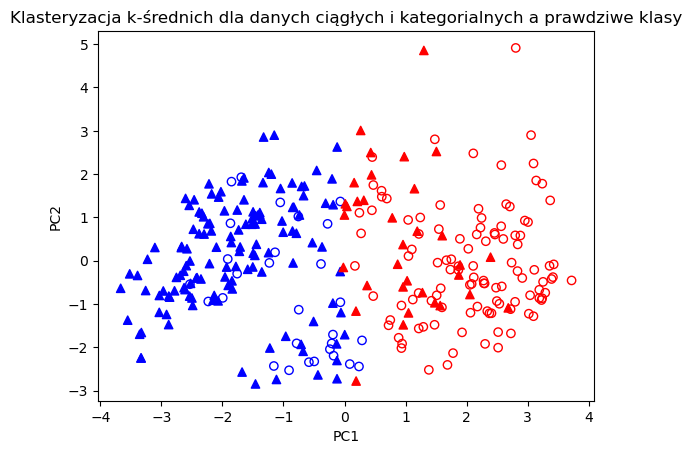

In [192]:
plt.scatter(heart_pca[y == 0,0], heart_pca[y == 0,1], edgecolors = np.array(["red", "blue"])[np.array(labels[y == 0])] , marker = 'o', facecolors = 'none')
plt.scatter(heart_pca[y == 1,0], heart_pca[y == 1,1], c = np.array(["red", "blue"])[np.array(labels[y == 1])] , marker = '^')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Klasteryzacja k-średnich dla danych ciągłych i kategorialnych a prawdziwe klasy")
plt.show()

# Grupowanie dużych danych

### Przykład 3: działanie algorytmu BIRCH i grupowania k-średnich na zbiorze danych blobs

Dla danych blobs zastosuj w pierwszym kroku algorytm BIRCH, a następnie klasteryzację 
k-średnich. Porównaj wyniki z klasteryzacją k-średnich bez wstępnego grupowania za pomocą BIRCH
oraz z grupowaniem BIRCH z zadaną liczbą klastrów. Sprawdź co się stanie jak w pierwszym kroku BIRCH wybierzesz threshold = 5.

In [56]:
X = make_blobs(n_samples = 2000, centers = 7, random_state = 7)[0]

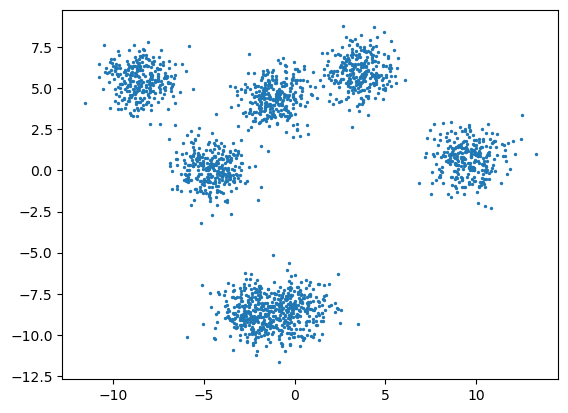

In [57]:
plt.scatter(X[:,0], X[:,1], s = 2)
plt.show()

In [59]:
model_birch = Birch(n_clusters = None) # final clustering is not performed, subclusters are returned as they are

In [60]:
model_birch.fit(X)
centers_birch = model_birch.subcluster_centers_
labels_birch = model_birch.labels_

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html

In [62]:
centers_birch.shape

(161, 2)

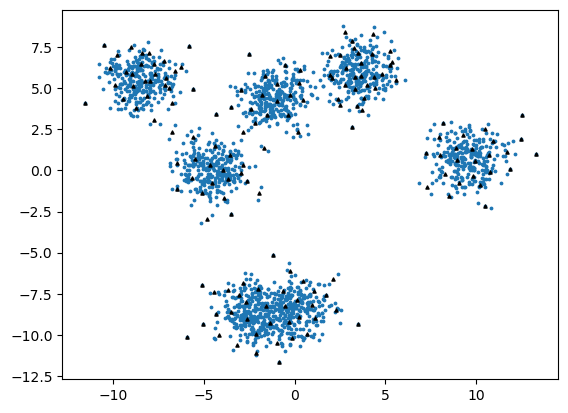

In [63]:
plt.scatter(X[:,0], X[:,1], s = 3)
plt.scatter(centers_birch[:,0], centers_birch[:,1], c = "black", marker = "^", s = 5)
plt.show()

In [65]:
labels_birch[:10]

array([ 35, 160,  37,   0,  83,  72, 111, 116,  97,  35])

In [66]:
labels_birch.shape

(2000,)

In [67]:
Xsmall = centers_birch

In [68]:
wss = []
sil_score = []
for i in range(1, 15):
    model_kmeans = KMeans(n_clusters = i, n_init = 10, random_state = 7)
    model_kmeans.fit(Xsmall)
    wss.append(model_kmeans.inertia_)
    if i>1:
        sil_score.append(silhouette_score(Xsmall, model_kmeans.labels_))

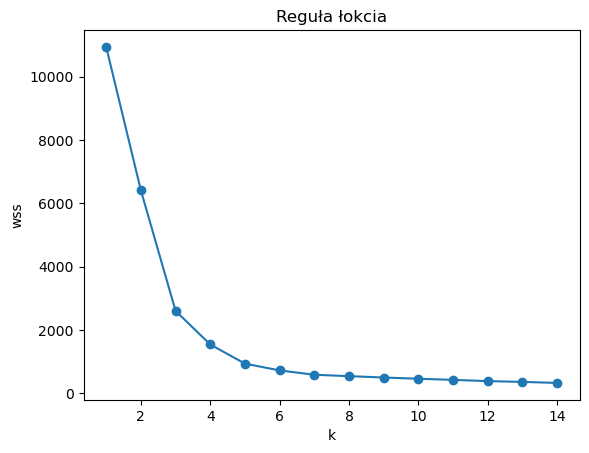

In [69]:
plt.plot(range(1, 15), wss, "-o")
plt.title("Reguła łokcia")
plt.xlabel("k")
plt.ylabel("wss")
plt.show()

In [72]:
kl = KneeLocator(range(1, 15), wss, curve = "convex", direction = "decreasing")
kl.elbow

4

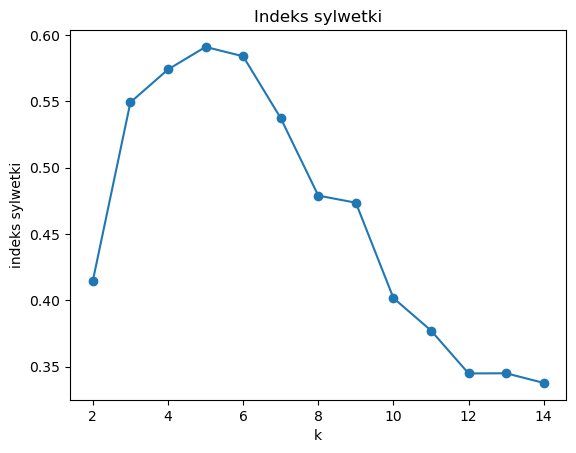

In [73]:
plt.plot(range(2, 15), sil_score, "-o")
plt.title("Indeks sylwetki")
plt.xlabel("k")
plt.ylabel("indeks sylwetki")
plt.show()

In [74]:
model_kmeans = KMeans(n_clusters = 5, n_init = 10, random_state = 7)
model_kmeans.fit(Xsmall)
centers_kmeans = model_kmeans.cluster_centers_
labels_kmeans = model_kmeans.labels_

In [75]:
labels_birch.shape

(2000,)

In [76]:
labels_kmeans.shape

(161,)

In [77]:
labels_fin = labels_kmeans[labels_birch]

In [78]:
np.bincount(labels_fin)

array([571, 458, 285, 286, 400])

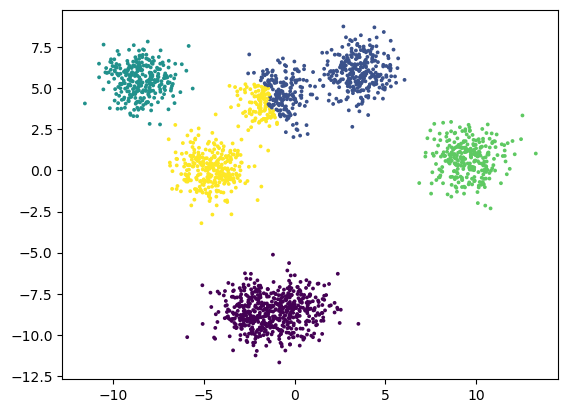

In [79]:
plt.scatter(X[:,0], X[:,1], c = labels_fin, s = 3)
plt.show()

In [80]:
model_birch2 = Birch(n_clusters = KMeans(5, n_init = 10, random_state = 7))
model_birch2.fit(X)

Birch(n_clusters=KMeans(n_clusters=5, n_init=10, random_state=7))

In [81]:
np.bincount(model_birch2.labels_)

array([571, 458, 285, 286, 400])

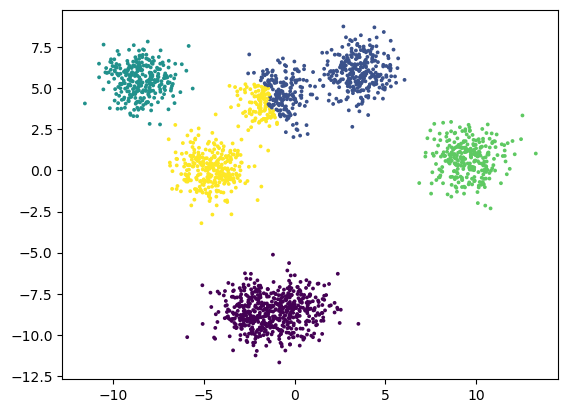

In [82]:
plt.scatter(X[:,0], X[:,1], c = model_birch2.labels_, s = 3)
plt.show()

K-średnich dla pełnych danych

In [84]:
wss2 = []
sil_score2 = []
for i in range(1, 15):
    model_kmeans2 = KMeans(n_clusters = i, n_init = 10, random_state = 7)
    model_kmeans2.fit(X)
    wss2.append(model_kmeans2.inertia_)
    if i>1:
        sil_score2.append(silhouette_score(X, model_kmeans2.labels_))

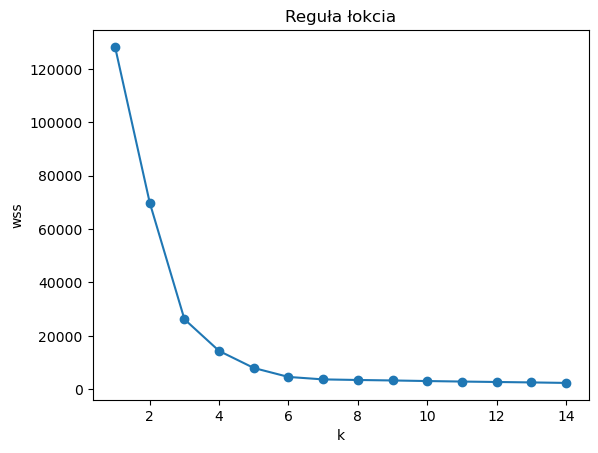

In [85]:
plt.plot(range(1, 15), wss2, "-o")
plt.title("Reguła łokcia")
plt.xlabel("k")
plt.ylabel("wss")
plt.show()

In [86]:
kl = KneeLocator(range(1, 15), wss2, curve = "convex", direction = "decreasing")
kl.elbow

4

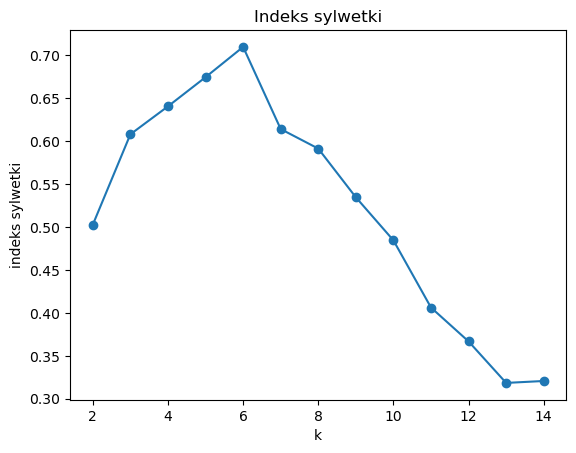

In [87]:
plt.plot(range(2, 15), sil_score2, "-o")
plt.title("Indeks sylwetki")
plt.xlabel("k")
plt.ylabel("indeks sylwetki")
plt.show()

In [88]:
model_kmeans2 = KMeans(n_clusters = 6, n_init = 10, random_state = 7)
model_kmeans2.fit(X)

KMeans(n_clusters=6, n_init=10, random_state=7)

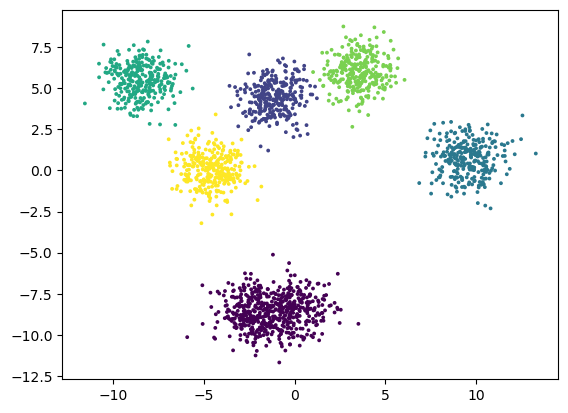

In [89]:
plt.scatter(X[:,0], X[:,1], c = model_kmeans2.labels_, s = 3)
plt.show()

Birch z threshold = 5

In [90]:
model_birch3 = Birch(n_clusters = None, threshold = 5)
model_birch3.fit(X)

Birch(n_clusters=None, threshold=5)

In [92]:
centers_birch3 = model_birch3.subcluster_centers_
centers_birch3 # Uwaga na wymiar i dopasowanie threshold!!!

array([[ 6.55925546,  3.33426455],
       [-4.7270908 ,  3.31289009],
       [-1.21334393, -8.58927799]])

Birch dla pełnych danych, znana liczba klastrów

In [93]:
model_birch4 = Birch(n_clusters = 7)
model_birch4.fit(X)

Birch(n_clusters=7)

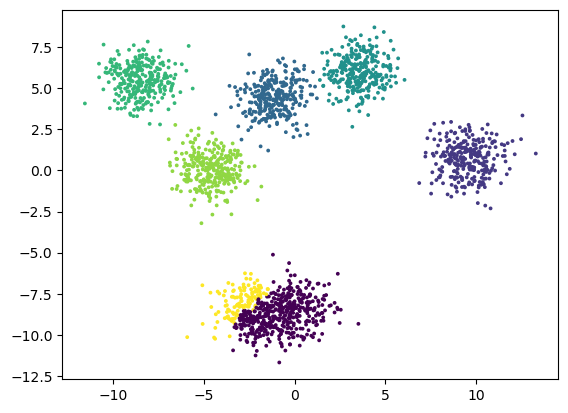

In [94]:
plt.scatter(X[:,0], X[:,1], c = model_birch4.labels_, s = 3)
plt.show()

### Ćwiczenie 3: działanie algorytmu BIRCH i grupowania aglomeracyjnego na zbiorze danych blobs

Powtórz analizę dla danych blobs dla klasteryzacji aglomeracyjnej. Zastosuj w pierwszym kroku algorytm BIRCH, a następnie klasteryzację aglomeracyjną. Porównaj wyniki z klasteryzacją aglomeracyjną bez wstępnego grupowania za pomocą BIRCH.

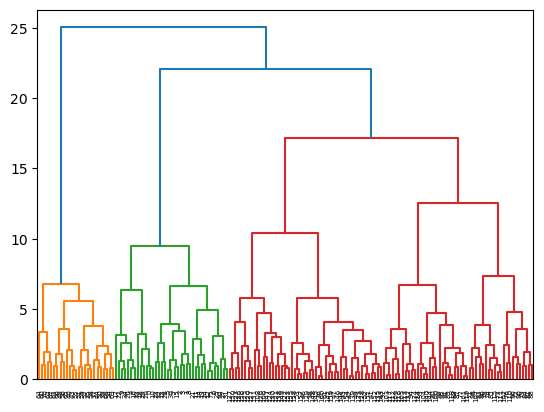

In [97]:
L1 = linkage(Xsmall, method = "complete", metric = "euclidean")
dendrogram(L1)
plt.show()

In [98]:
clust1 = fcluster(L1, 4, criterion = "maxclust")

In [99]:
labels_fin2 = clust1[labels_birch]

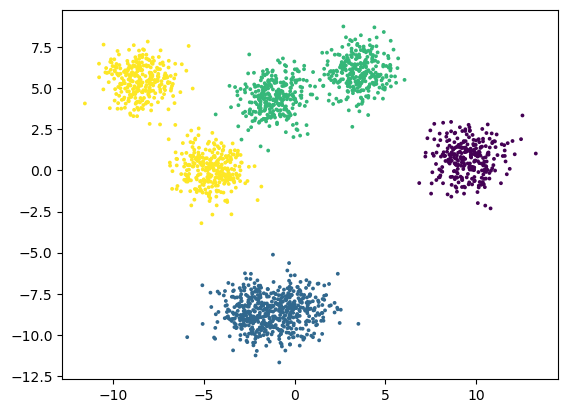

In [100]:
plt.scatter(X[:,0], X[:,1], c = labels_fin2, s = 3)
plt.show()

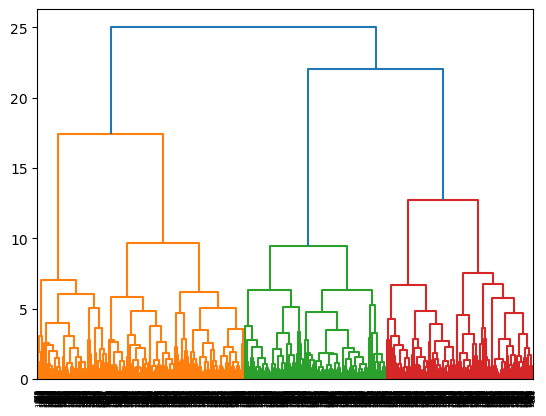

In [101]:
L2 = linkage(X, method = "complete", metric = "euclidean")
dendrogram(L2)
plt.show()

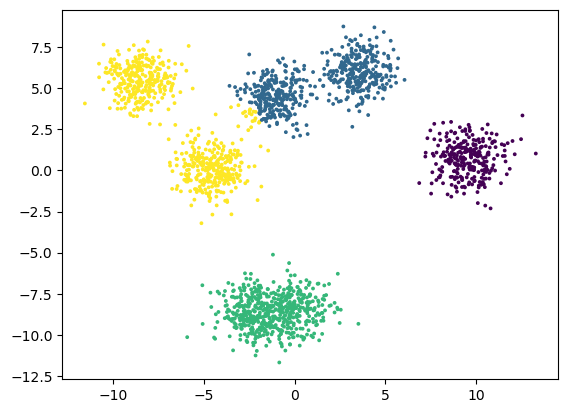

In [102]:
clust2 = fcluster(L2, 4, criterion = "maxclust")
plt.scatter(X[:,0], X[:,1], c = clust2, s = 3)
plt.show()

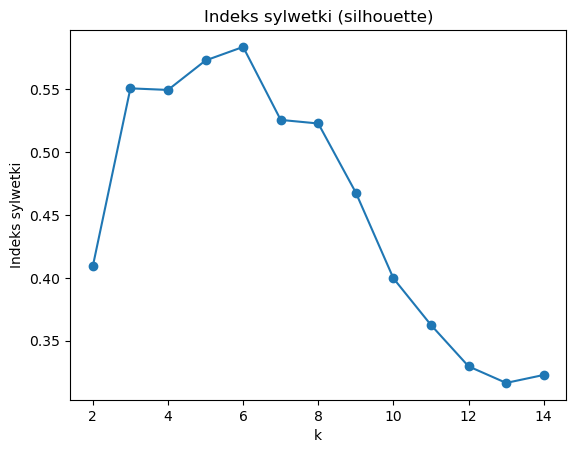

In [103]:
# rozwiązanie Michała, z wykorzystaniem silhouette score, k=6.
sil_score = []

for i in range(2, 15):
    
    model = AgglomerativeClustering(n_clusters=i, linkage="ward")
    model.fit(Xsmall)
    
    sil_score.append(silhouette_score(Xsmall, model.labels_))  # silhouette
    
plt.plot(range(2, 15), sil_score, "-o")

plt.title("Indeks sylwetki (silhouette)")
plt.xlabel("k")
plt.ylabel("Indeks sylwetki")
plt.show()
## wybieramy maksymalny indeks sylwetki (k=6)



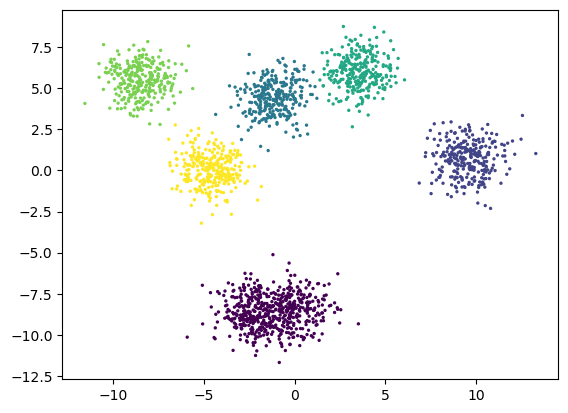

In [104]:
model_agg = AgglomerativeClustering(n_clusters=6, linkage="ward")
model_agg.fit(Xsmall)

labels_fin = model_agg.labels_[labels_birch]

plt.scatter(X[:, 0], X[:, 1], c=labels_fin, s=2)
plt.show()

In [105]:
# Dla pełnych danych aglomeracyjny + indeks sylwetki też daje 6 klastrów

## Grupowanie Mini-Batch K-Means

### Przykład 4: porównanie algorytmów K-Means i Mini-Batch K-Means na danych blobs

Dla danych blobs (jak wyżej) porównaj działanie algorytmów K-Means i Mini-Batch K-Means dla liczby klastrów równej 7: 
    oblicz czasy działania algorytmów i wss znalezionych grupowań. Dla jakiej części obserwacji algorytmy 
    przyporządkowały je do różnych klastrów?

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html

In [106]:
X = make_blobs(n_samples = 2000, centers = 7, random_state = 7)[0]

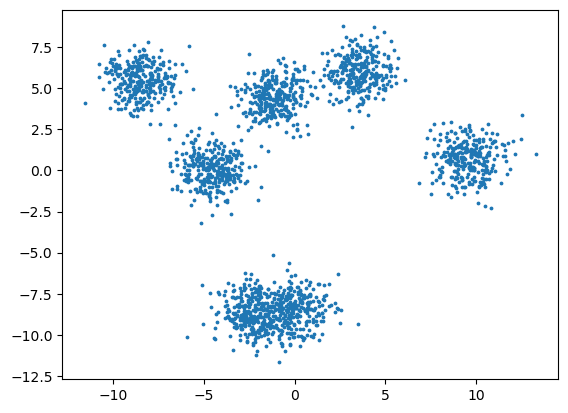

In [108]:
plt.scatter(X[:,0], X[:,1], s = 3)
plt.show()

In [116]:
kmeans = KMeans(n_clusters =7, n_init = 10, random_state = 13)
t0 = time.time()
kmeans.fit(X)
t_kmeans = time.time() - t0

In [117]:
wyniki = pd.DataFrame(columns = ["KMeans", "Mini-Batch KMeans"], index = ["czas", "wss"])

In [118]:
wyniki["KMeans"] = [t_kmeans, kmeans.inertia_]

In [119]:
batch_size = 200
mbk = MiniBatchKMeans(n_clusters = 7, batch_size = batch_size, n_init = 10, random_state = 13)
t0 = time.time()
mbk.fit(X)
t_mbk = time.time() - t0

In [120]:
wyniki["Mini-Batch KMeans"] = [t_mbk, mbk.inertia_]

In [121]:
wyniki

,KMeans,Mini-Batch KMeans
czas,1.889225,0.818280
wss,3712.746327,3724.814639


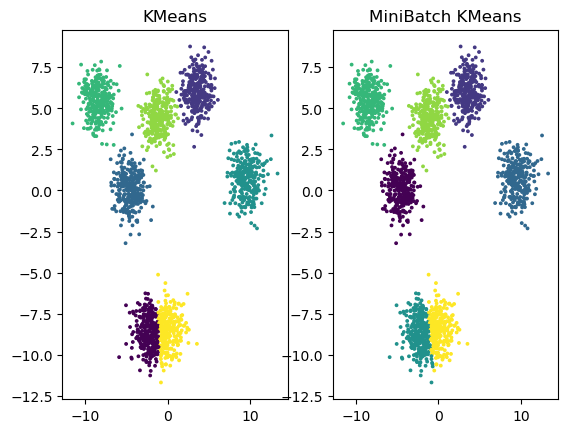

In [123]:

plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c = kmeans.labels_, s = 3)
plt.title("KMeans")
plt.subplot(122)
plt.scatter(X[:,0], X[:,1], c = mbk.labels_, s = 3)
plt.title("MiniBatch KMeans")
plt.show()

In [124]:
print(pd.crosstab(kmeans.labels_, mbk.labels_))

col_0    0    1    2    3    4    5    6
row_0                                   
0        0    0    0  302    0    0    0
1        0  280    0    0    0    0    0
2      286    0    0    0    0    0    0
3        0    0  286    0    0    0    0
4        0    0    0    0  286    0    0
5        0    0    0    0    0  291    0
6        0    0    0   11    0    0  258


In [125]:
11/2000

0.0055

### Ćwiczenie 4: porównanie BIRCH, K-Means i Mini-Batch K-Means

Dla danych blobs z 1 00 000 obserwacji  porównaj działanie algorytmów BIRCH, KMeans i Mini-Batch K-Means dla liczby 
klastrów równej 100: oblicz czasy działania algorytmów i ARI znalezionych grupowań. Dla algorytmu BIRCH wypróbuj dwie 
metody grupowania w drugim kroku: aglomeracyjne z metodą Warda oraz k-średnich.

In [126]:
X, labels = make_blobs(100000, centers = 100, center_box=[0,100], random_state=7)

In [128]:
batch_size = 256*cpu_count()

In [129]:
batch_size

1024

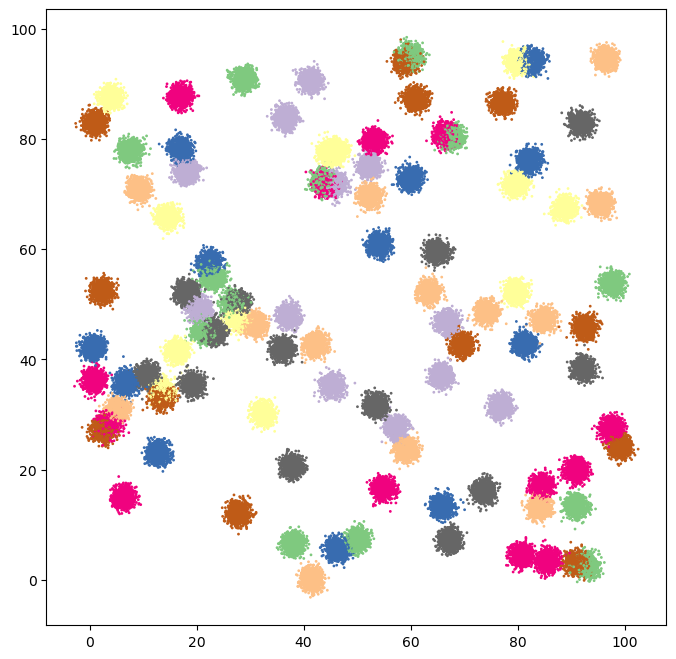

In [127]:
plt.figure(figsize = (8,8))
plt.scatter(X[:,0], X[:,1], s = 1, c = labels, cmap = "Accent")
plt.show()

In [131]:
wyniki = pd.DataFrame(columns = ["BIRCH agg ward", "BIRCH agg KMeans", "KMeans", "Mini-Batch KMeans"],
                     index = ["czas", "ARI"])

In [132]:
model_birch1 = Birch(n_clusters = AgglomerativeClustering(n_clusters = 100, linkage = "ward"))
t0 = time.time()
model_birch1.fit(X)
t_birch = time.time() - t0

In [133]:
wyniki["BIRCH agg ward"] = [t_birch, adjusted_rand_score(labels, model_birch1.labels_)]

In [134]:
len(model_birch1.subcluster_centers_)

3301

In [135]:
model_birch2 = Birch(n_clusters = KMeans(100, n_init = 10))
t0 = time.time()
model_birch2.fit(X)
t_birch2 = time.time() - t0

In [136]:
wyniki["BIRCH agg KMeans"] = [t_birch2, adjusted_rand_score(labels, model_birch2.labels_)]

In [137]:
wyniki

,BIRCH agg ward,BIRCH agg KMeans,KMeans,Mini-Batch KMeans
czas,23.241106,23.474072,NaN,NaN
ARI,0.846267,0.868182,NaN,NaN


In [144]:
mbk = MiniBatchKMeans(n_clusters = 100, batch_size = batch_size, n_init = 10, random_state = 13)
t0 = time.time()
mbk.fit(X)
t_mbk = time.time() - t0

In [147]:
wyniki["Mini-Batch KMeans"] = [t_mbk, adjusted_rand_score(labels, mbk.labels_)]

In [148]:
wyniki

,BIRCH agg ward,BIRCH agg KMeans,KMeans,Mini-Batch KMeans
czas,23.241106,23.474072,46.946293,6.902662
ARI,0.846267,0.868182,0.886310,0.866323


In [141]:
kmeans = KMeans(100, n_init = 10, random_state = 7)
t0 = time.time()
kmeans.fit(X)
t_kmeans = time.time() - t0

In [142]:
wyniki["KMeans"] = [t_kmeans, adjusted_rand_score(labels, kmeans.labels_)]

In [146]:
wyniki

,BIRCH agg ward,BIRCH agg KMeans,KMeans,Mini-Batch KMeans
czas,23.241106,23.474072,46.946293,6.902662
ARI,0.846267,0.868182,0.886310,0.866323


## Ćwiczenie poznanych metod

### Ćwiczenie 5: zbiór danych digits

Pogrupuj dane.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html

In [149]:
digits = load_digits()
X = digits.data
y = digits.target

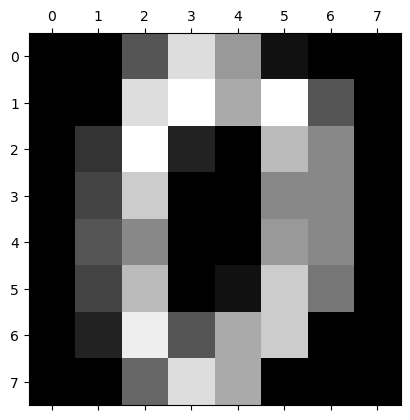

In [150]:
plt.matshow(digits.images[0], cmap = 'gray')
plt.show()

In [151]:
pd.DataFrame(digits.data).describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,16.000000,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


In [152]:
X.shape

(1797, 64)

In [153]:
np.bincount(y)

array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180])

In [154]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

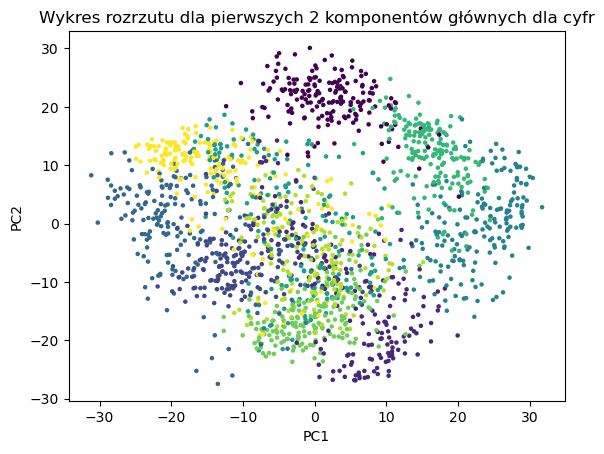

In [155]:
plt.scatter(X_pca[:,0], X_pca[:,1], s = 5, c = y)
plt.title("Wykres rozrzutu dla pierwszych 2 komponentów głównych dla cyfr")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [156]:
wss = []
sil_score = []
for i in range(1, 20):
    model = KMeans(n_clusters = i, n_init = 10, random_state = 7)
    model.fit(X)
    wss.append(model.inertia_)
    if i>1:
        sil_score.append(silhouette_score(X, model.labels_))

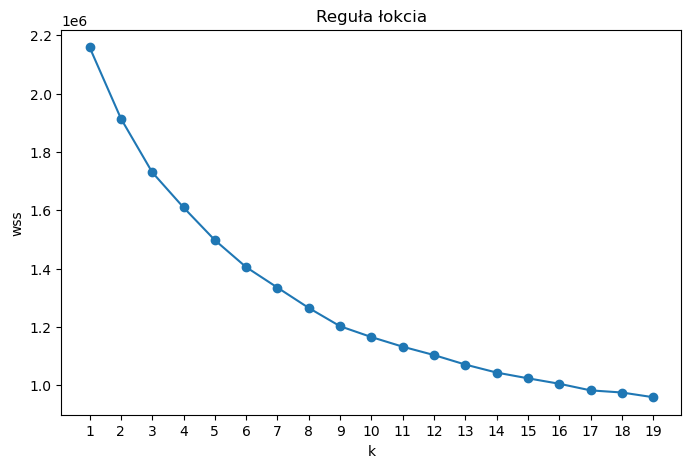

In [157]:
plt.figure(figsize = (8, 5))
plt.plot(range(1, 20), wss, "-o")
plt.xticks (range(1,20))
plt.title("Reguła łokcia")
plt.xlabel("k")
plt.ylabel("wss")
#plt.savefig('lokiec.png')
plt.show()

In [158]:
kl = KneeLocator(range(1, 20), wss, curve="convex", direction="decreasing")
kl.elbow

8

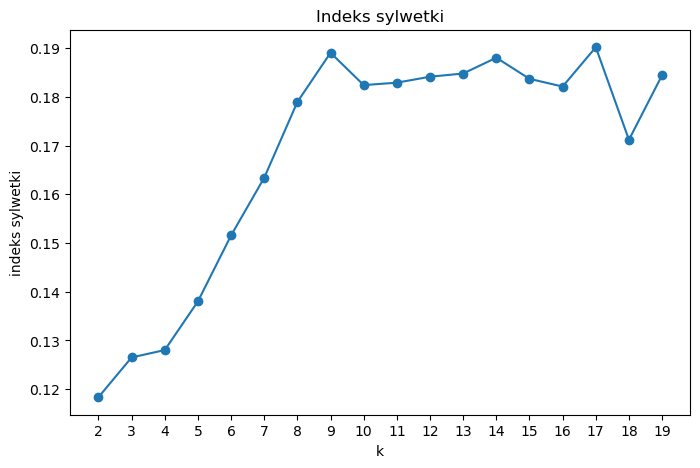

In [159]:
plt.figure(figsize = (8, 5))
plt.plot(range(2, 20), sil_score, "-o")
plt.title("Indeks sylwetki")
plt.xlabel("k")
plt.ylabel("indeks sylwetki")
plt.xticks (range(2,20))
#plt.savefig('sylwetka.png')
plt.show()

In [160]:
model = KMeans(n_clusters = 9, n_init = 10, random_state = 7)
model.fit(X)
labels = model.labels_ 

In [161]:
adjusted_rand_score(labels, y)

0.595214029457347

In [163]:
model = KMeans(n_clusters = 10, n_init = 10, random_state = 7)
model.fit(X)
labels = model.labels_ 

In [164]:
adjusted_rand_score(labels, y)

0.6673324909505219

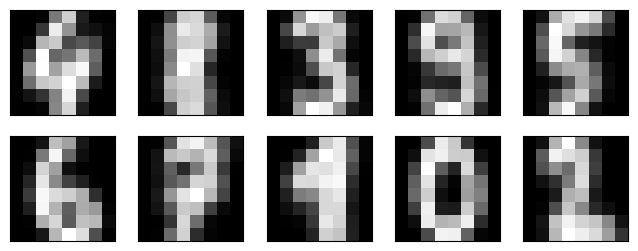

In [166]:
fig, ax = plt.subplots(2, 5, figsize = (8,3))
centers = model.cluster_centers_.reshape(10,8,8) 
for axi, center in zip(ax.flat, centers):
    axi.set(xticks = [], yticks = [])
    axi.imshow(center, cmap = 'gray')

In [167]:
L1 = linkage(X, method='ward', metric='euclidean')

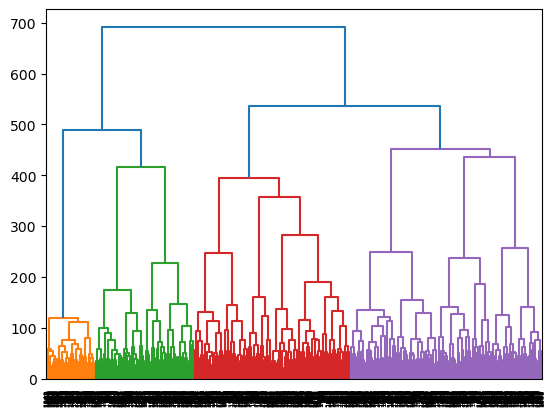

In [168]:
dendrogram(L1)
plt.show()

In [169]:
clust1 = fcluster(L1, 9, criterion='maxclust')

In [170]:
adjusted_rand_score(clust1, y)

0.7470288652295264

In [171]:
clust2 = fcluster(L1, 10, criterion='maxclust')

In [172]:
adjusted_rand_score(clust2, y)

0.7940031835568753

## Źródła:

Hastie, Trevor, et al. The elements of statistical learning: data mining, inference, and prediction. Vol. 2. New York: springer, 2009.

Muller, Andreas, et al. Machine learning, Python i data science, Wprowadzenie. Helion, 2021.

https://en.wikipedia.org/wiki/Rand_index

https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/

https://medium.com/analytics-vidhya/the-ultimate-guide-for-clustering-mixed-data-1eefa0b4743b

https://www.coryjmaklin.com/2019-07-01_Machine-Learning--BIRCH-Clustering-Algorithm-Clearly-Explained-fb9838cbeed9/

https://www.geeksforgeeks.org/ml-mini-batch-k-means-clustering-algorithm/

https://www.kaggle.com/code/ksavleen/handwritten-digit-recognition-kmeans-clustering/notebook

